In [1]:
# init
from mmpretrain.utils import register_all_modules

register_all_modules()

/opt/conda/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# build a model
from mmpretrain.registry import MODELS

model = dict(
    type='ImageClassifier',
    backbone=dict(type='ResNet', depth=50),
    neck=dict(type='GlobalAveragePooling'),
    head=dict(
        type='LinearClsHead',
        num_classes=1000,
        in_channels=2048,
        loss=dict(type='CrossEntropyLoss')),
    data_preprocessor = dict(
        mean=[123.675, 116.28, 103.53], std=[58.395, 57.12, 57.375], to_rgb=True),
    init_cfg=dict(
        type='Pretrained',
        checkpoint='https://download.openmmlab.com/mmpretrain/v0/resnet/resnet50_8xb32_in1k_20210831-ea4938fc.pth'))
model = MODELS.build(model)
model.init_weights()
model.cuda()
model.eval()
'initialized model'

01/13 07:43:05 - mmengine - WARNING - The "model" registry in mmpretrain did not set import location. Fallback to call `mmpretrain.utils.register_all_modules` instead.
01/13 07:43:05 - mmengine - WARNING - The "weight initializer" registry in mmpretrain did not set import location. Fallback to call `mmpretrain.utils.register_all_modules` instead.
01/13 07:43:05 - mmengine - INFO - load model from: https://download.openmmlab.com/mmpretrain/v0/resnet/resnet50_8xb32_in1k_20210831-ea4938fc.pth
01/13 07:43:05 - mmengine - INFO - Loads checkpoint by http backend from path: https://download.openmmlab.com/mmpretrain/v0/resnet/resnet50_8xb32_in1k_20210831-ea4938fc.pth


'initialized model'

In [3]:
# build a pipeline
from mmengine.dataset import Compose

pipeline = [
    dict(type='LoadImageFromFile', to_float32=True),
#   dict(type='Resize', scale=600),
#   dict(type='CenterCrop', crop_size=448),
    dict(type='PackClsInputs')
]
pipeline = Compose(pipeline)

01/13 07:43:07 - mmengine - WARNING - The "transform" registry in mmpretrain did not set import location. Fallback to call `mmpretrain.utils.register_all_modules` instead.


In [4]:
# process data
from mmengine.dataset import default_collate

results = dict(img_path='../tests/data/color.jpg')
data_batch = pipeline(results)
data_batch['inputs'] = data_batch['inputs'].to(next(model.parameters()).device)
data_batch = default_collate([data_batch])

/opt/conda/lib/python3.7/site-packages/mmengine/visualization/visualizer.py:170: UserWarning: `Visualizer` backend is not initialized because save_dir is None.
  warnings.warn('`Visualizer` backend is not initialized '


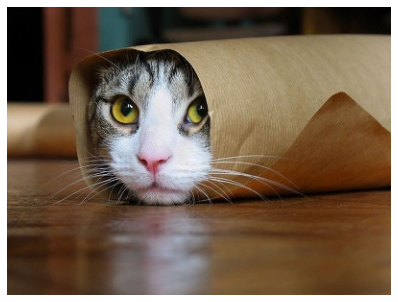

In [5]:
# set visualizer for saliency
from mmpretrain.visualization import ClsVisualizer

visualizer = ClsVisualizer.get_instance('visualizer')

img = data_batch['inputs'][0].detach().cpu().numpy()
img = img[::-1].transpose(1, 2, 0) / 255
visualizer.show(img)

In [6]:
# ready to generate binary mask by thresholds
import matplotlib.pyplot as plt
import numpy as np

def generate_masks(attr):
    fig, ax = plt.subplots(1, 5, figsize=(25, 25))
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
    thrs = (10, 30, 50, 70, 90)
    for i, thr in enumerate(np.percentile(attr, thrs[::-1])):
        ax[i].imshow(attr >= thr)
        ax[i].axis(False)
        ax[i].set_title(f'{thrs[i]}%')
    plt.tight_layout()

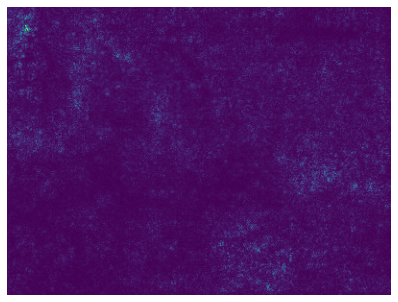

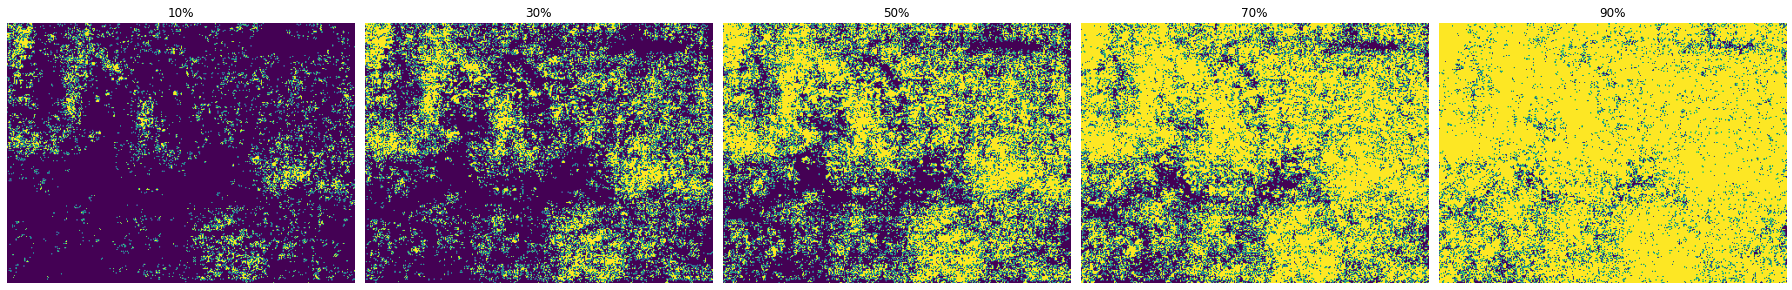

In [7]:
# compute image gradient
from roar.estimation import Gradient

grad = Gradient(model)
attr = grad(data_batch)[0].cpu().numpy()
attr = attr.mean(axis=0)
generate_masks(attr)
visualizer.show(attr)

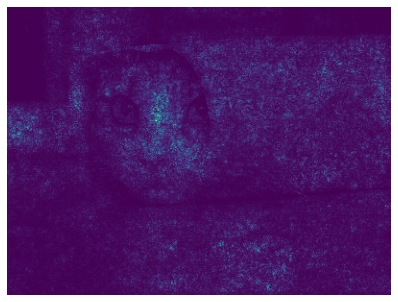

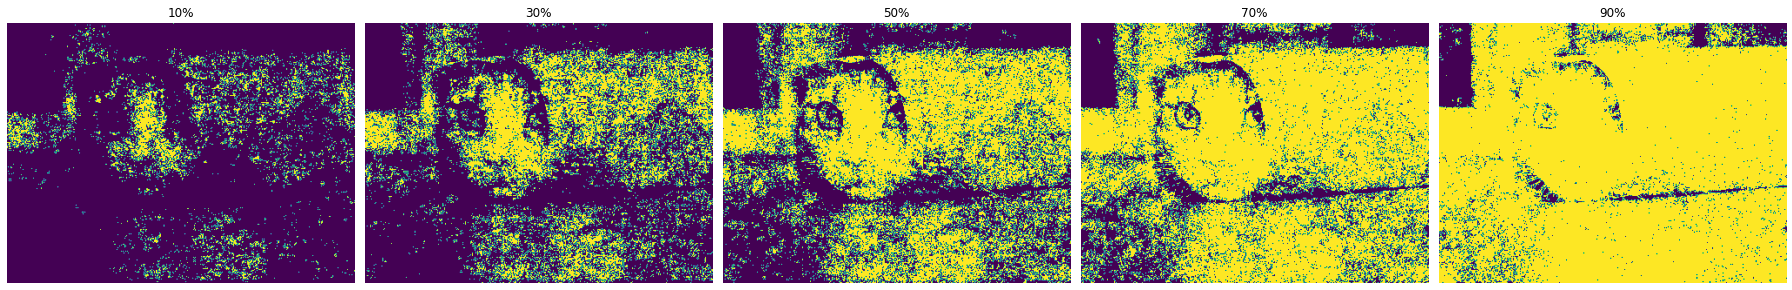

In [8]:
# compute gradient times input
from roar.estimation import GradientTimesInput

gi = GradientTimesInput(model)
attr = gi(data_batch)[0].cpu().numpy()
attr = attr.mean(axis=0)
mask = generate_masks(attr)
visualizer.show(attr)

01/13 07:43:11 - mmengine - WARNING - Failed to search registry with scope "mmpretrain" in the "attribute" registry tree. As a workaround, the current "attribute" registry in "roar" is used to build instance. This may cause unexpected failure when running the built modules. Please check whether "mmpretrain" is a correct scope, or whether the registry is initialized.


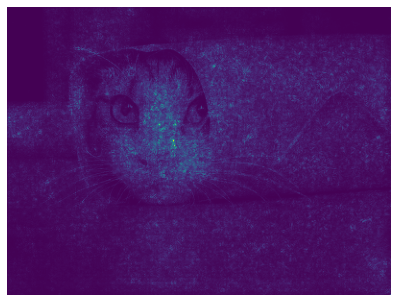

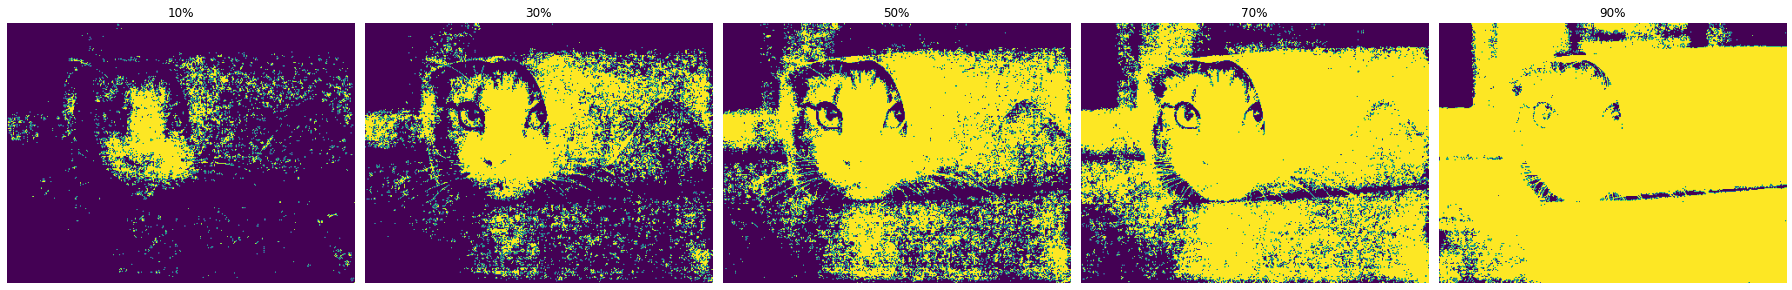

In [9]:
# compute integrated gradients
from roar.estimation import IntegratedGradients

ig = IntegratedGradients(model)
attr = ig(data_batch)[0].cpu().numpy()
attr = attr.mean(axis=0)
mask = generate_masks(attr)
visualizer.show(attr)

01/13 07:43:12 - mmengine - WARNING - Failed to search registry with scope "mmpretrain" in the "attribute" registry tree. As a workaround, the current "attribute" registry in "roar" is used to build instance. This may cause unexpected failure when running the built modules. Please check whether "mmpretrain" is a correct scope, or whether the registry is initialized.


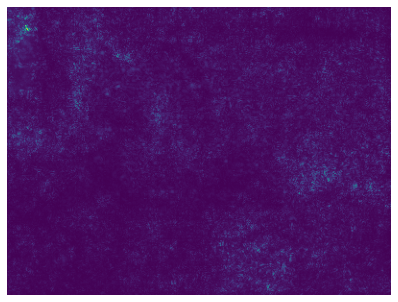

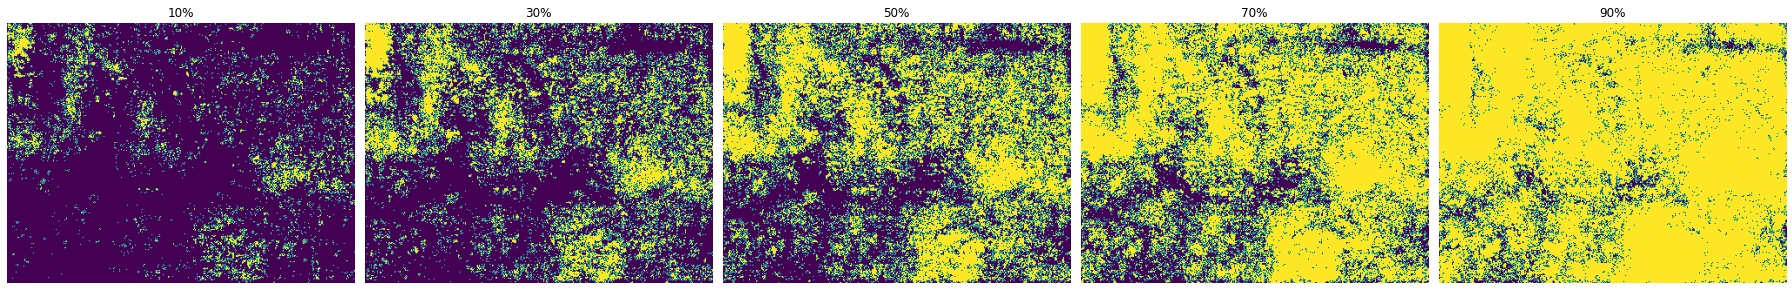

In [10]:
# compute smooth grad
from roar.estimation import SmoothGrad

sg = SmoothGrad(model)
attr = sg(data_batch)[0].cpu().numpy()
attr = attr.mean(axis=0)
mask = generate_masks(attr)
visualizer.show(attr)

01/13 07:43:13 - mmengine - WARNING - Failed to search registry with scope "mmpretrain" in the "attribute" registry tree. As a workaround, the current "attribute" registry in "roar" is used to build instance. This may cause unexpected failure when running the built modules. Please check whether "mmpretrain" is a correct scope, or whether the registry is initialized.


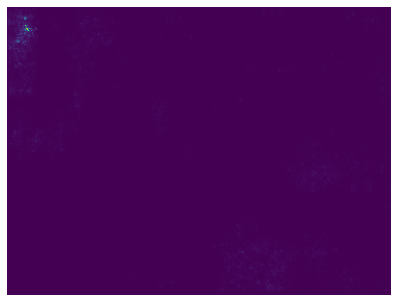

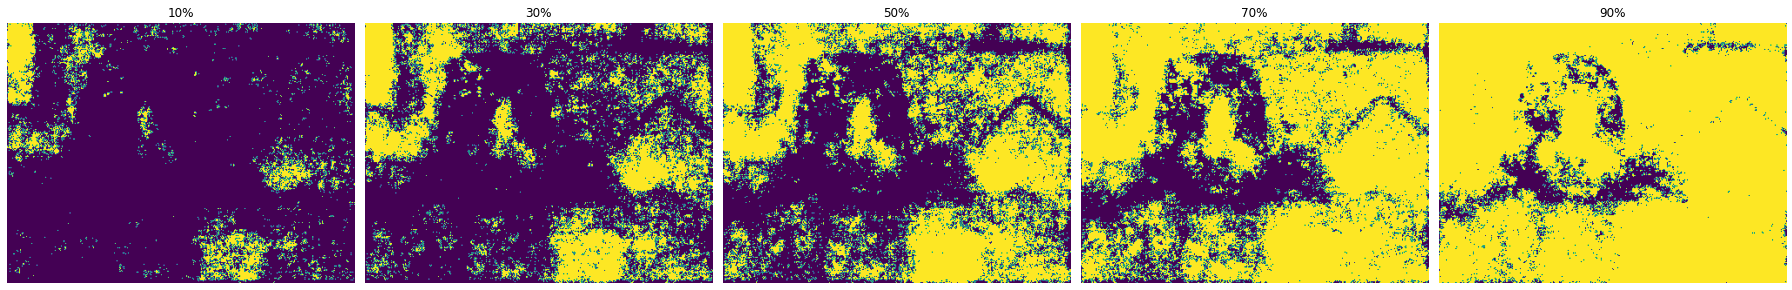

In [11]:
# compute var grad
from roar.estimation import VarGrad

vg = VarGrad(model)
attr = vg(data_batch)[0].cpu().numpy()
attr = attr.mean(axis=0)
mask = generate_masks(attr)
visualizer.show(attr)

/opt/conda/lib/python3.7/site-packages/torch/nn/modules/module.py:1053: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


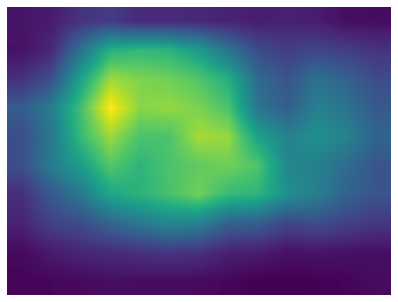

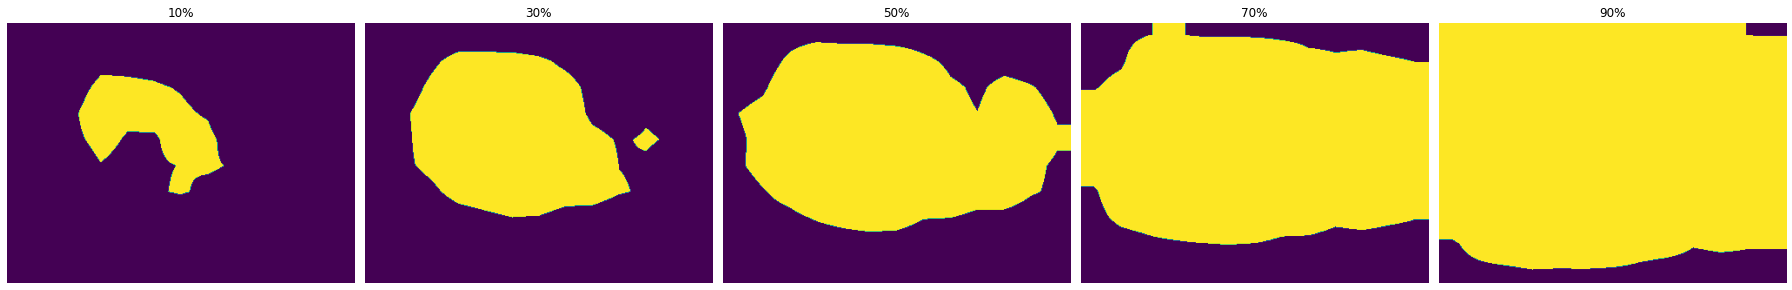

In [12]:
# compute grad cam
from roar.estimation import GradCAM

gc = GradCAM(model, module='backbone.layer4')
attr = gc(data_batch)[0].cpu().numpy()
attr = attr.mean(axis=0)
mask = generate_masks(attr)
visualizer.show(attr)

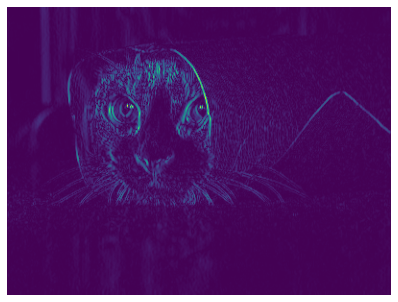

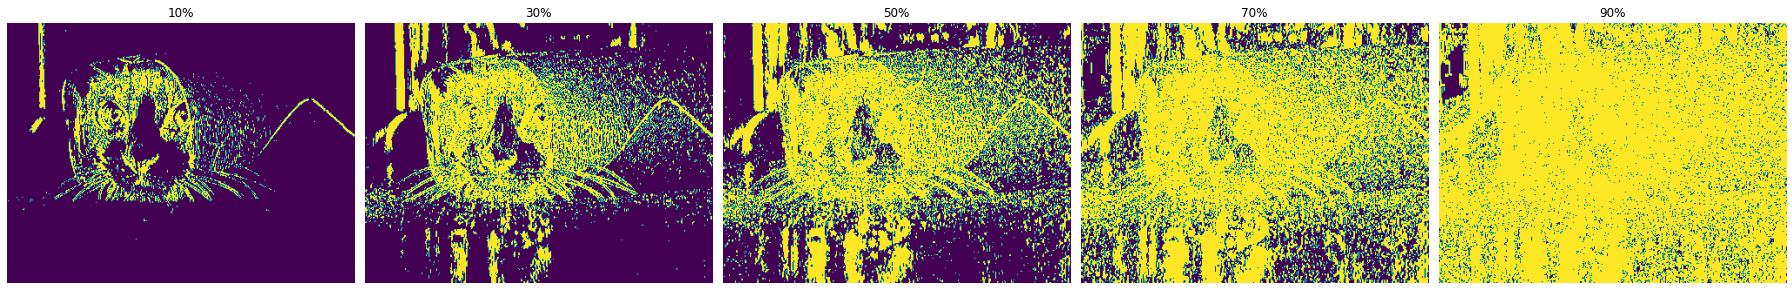

In [13]:
# compute sobel
from roar.estimation import Sobel

sobl = Sobel(model)
attr = sobl(data_batch)[0].cpu().numpy()
attr = attr.mean(axis=0)
mask = generate_masks(attr)
visualizer.show(attr)

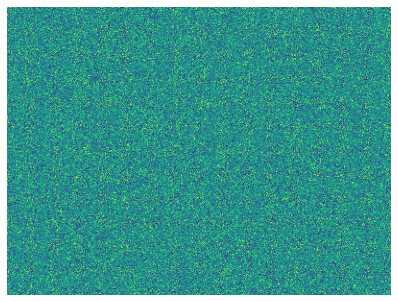

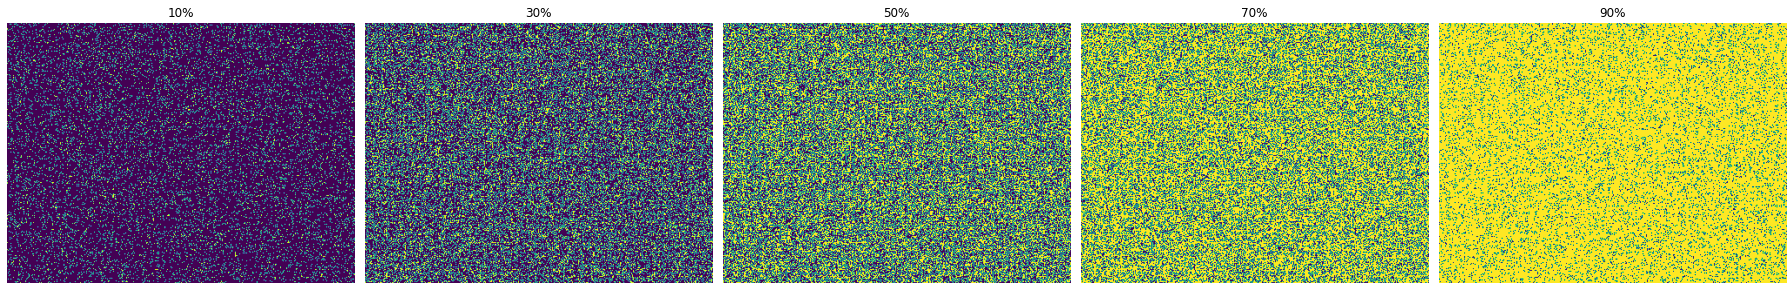

In [14]:
# compute random
from roar.estimation import Random

rand = Random(model)
attr = rand(data_batch)[0].cpu().numpy()
attr = attr.mean(axis=0)
mask = generate_masks(attr)
visualizer.show(attr)